[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/calebweinreb/keypointMoSeq/blob/user_friendly_pipeline/examples/keypointMoSeq_demo_colab.ipynb)
## Keypoint MoSeq 

#### This notebook illustrates how to fit a keypoint-SLDS model using pose tracking data (e.g. from DeepLabCut)

- Make sure keypoint_moseq is [installed](XXX)
- Change the kernel to `keypoint_moseq`
- Download the [example data](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
print(jax.devices())
print(jax.__version__)

[StreamExecutorGpuDevice(id=0, process_index=0)]
0.4.1


In [3]:
from jax.config import config
config.update('jax_enable_x64', True)
import keypoint_moseq as kpm

### Find paths for sleap videos by searching recursively within a directory

In [4]:
video_dir = r'D:/data/pair_wt_gold/' 
sleap_paths = kpm.project.get_sleap_paths(video_dir)
print(sleap_paths)

D:\data\pair_wt_gold\190612_110405_wt_16276625_rig2.1\inference.h5
D:\data\pair_wt_gold\190612_110405_wt_18159111_rig2.2\inference.h5
D:\data\pair_wt_gold\190612_110639_wt_18159211_rig1.1\inference.h5
D:\data\pair_wt_gold\190612_110953_wt_18159112_rig3.2\inference.h5
D:\data\pair_wt_gold\190612_110953_wt_18159203_rig3.1\inference.h5
['D:\\data\\pair_wt_gold\\190612_110405_wt_16276625_rig2.1\\inference.h5', 'D:\\data\\pair_wt_gold\\190612_110405_wt_18159111_rig2.2\\inference.h5', 'D:\\data\\pair_wt_gold\\190612_110639_wt_18159211_rig1.1\\inference.h5', 'D:\\data\\pair_wt_gold\\190612_110953_wt_18159112_rig3.2\\inference.h5', 'D:\\data\\pair_wt_gold\\190612_110953_wt_18159203_rig3.1\\inference.h5']


### Setup a new project
- Edit `project_dir` and `dlc_config` below so that `dlc_config` points to the example data.
- This step creates a new project directory with a MoSeq `config.yml` file.

In [5]:
project_dir = 'demo_sleap_project'

# option 1: set up from scratch
# kpm.setup_project(project_dir)

# option 2: set up from deeplabcut
# dlc_config = 'moseq_example-caleb-2022-11-09/config.yaml'
# kpm.setup_project(project_dir, deeplabcut_config=dlc_config, overwrite=True)
sample_slp_path = sleap_paths[0]
kpm.setup_project_from_slp(project_dir, sample_slp_file=sample_slp_path, overwrite=True)

# define config loader
config = lambda: kpm.load_config(project_dir)

### Edit the config file

- The config can be edited manually, or using `kpm.update_config`, as shown below.
- The cell below contains all config edits necessary to run this notebook on the example data.

In general, the following parameters should be specified for each project:

- `bodyparts` (The name of each keypoint; automatically imported if you setup from DLC)
- `use_bodyparts` (Subset of bodyparts to use for modeling; defaults to all if you setup from DLC)
- `anterior_bodyparts` and `posterior_bodyparts` (Used for rotational alignment)
- `video_dir` (directory with videos of each experiment; detaults to `[DLC project path]/videos` if you setup from DLC.


In [7]:
use_bodyparts = ['thorax', 'abdomen', 'wingL', 'wingR', 'forelegL4', 'forelegR4', 'midlegL4', 'midlegR4', 'hindlegL4', 'hindlegR4']

In [8]:
kpm.update_config(
    project_dir,
    use_bodyparts=use_bodyparts,
    anterior_bodyparts=['thorax'], posterior_bodyparts=['abdomen'],
    latent_dimension=10, slope= -0.47, intercept= 0.236721,
    pca_fitting_num_frames = 270000,
    keypoint_colormap = 'cool'
)

In [9]:
print(config())

{'bodyparts': ['head', 'thorax', 'abdomen', 'wingL', 'wingR', 'forelegL4', 'forelegR4', 'midlegL4', 'midlegR4', 'hindlegL4', 'hindlegR4', 'eyeL', 'eyeR'], 'use_bodyparts': ['thorax', 'abdomen', 'wingL', 'wingR', 'forelegL4', 'forelegR4', 'midlegL4', 'midlegR4', 'hindlegL4', 'hindlegR4'], 'skeleton': [['thorax', 'head'], ['thorax', 'abdomen'], ['thorax', 'wingL'], ['thorax', 'wingR'], ['thorax', 'forelegL4'], ['thorax', 'forelegR4'], ['thorax', 'midlegL4'], ['thorax', 'midlegR4'], ['thorax', 'hindlegL4'], ['thorax', 'hindlegR4'], ['head', 'eyeL'], ['head', 'eyeR']], 'anterior_bodyparts': ['thorax'], 'posterior_bodyparts': ['abdomen'], 'use_instance': 1, 'added_noise_level': 0.1, 'PCA_fitting_num_frames': 1000000, 'conf_threshold': 0.5, 'error_estimator': {'intercept': 0.236721, 'slope': -0.47}, 'obs_hypparams': {'nu_s': 5, 'nu_sigma': 100000.0, 'sigmasq_0': 0.1, 'sigmasq_C': 0.1}, 'ar_hypparams': {'K_0_scale': 10.0, 'S_0_scale': 0.01, 'nlags': 3}, 'trans_hypparams': {'alpha': 5.7, 'gamm

### Load data

Data can be loaded directly from DLC or from any another sources as long as it has the following format:
- `coordinates`: dict of (T,K,D) arrays where K is the number of keypoints and D is 2 or 3
- `confidences`: dict of (T,K) arrays of **nonzero** confidence scores for each keypoint

If applying keypoint-MoSeq to your own data, note that:
- `confidences` are optional (they are used to set the error prior for each observation)
- if importing from DLC, data are assumed to be .h5/.csv files in `video_dir`
- each key in `coordinates` should start with its video name 
    - e.g. `coordinates["experiment1etc"]` would correspond to `experiment1.avi`
    - in general this will already be true if importing from DLC

In [10]:
# load data from DLC
coordinates = kpm.load_keypoints_from_slp_list(sleap_paths, **config())

Reading coordinates from sleap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.80it/s]


In [11]:
for k,v in coordinates.items():
    print(k)
    print(v.shape)

190612_110405_wt_16276625_rig2.1
(270094, 13, 2)
190612_110405_wt_18159111_rig2.2
(126374, 13, 2)
190612_110639_wt_18159211_rig1.1
(270093, 13, 2)
190612_110953_wt_18159112_rig3.2
(132838, 13, 2)
190612_110953_wt_18159203_rig3.1
(50979, 13, 2)


In [12]:
# format for modeling (reshapes into fixed-length batches and moves to GPU)
data, batch_info = kpm.format_data(coordinates, **config())

### Fit PCA

Run the cell below to fit a PCA model to aligned keypoint coordinates. After fitting, two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 

- After fitting, edit `latent_dimension` in the config. A good heuristic is the number of dimensions needed to explain 90% of variance. 
- If your computer crashes at this step, try lowering `PCA_fitting_num_frames` in the config.

PCA: Performing egocentric alignment
PCA: Fitting PCA model on 852898 sample poses
>=90.0% of variance exlained by 11 components.


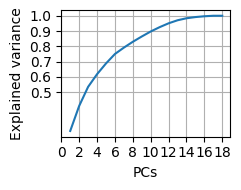

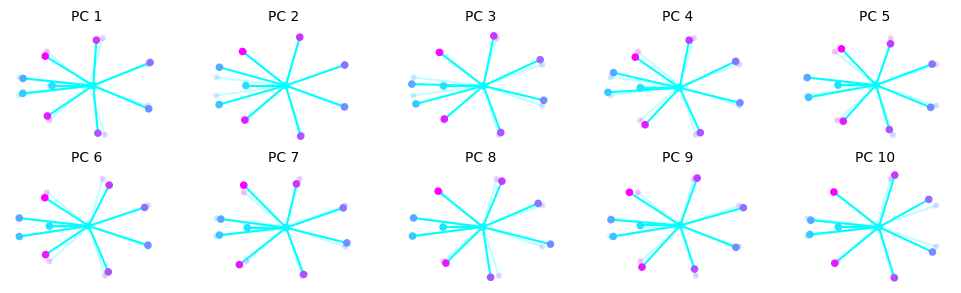

In [14]:
# uncomment if you have already fit pca
# pca = kpm.load_pca(project_dir)

pca = kpm.fit_pca(**data, **config(), conf=None)
kpm.save_pca(pca, project_dir)

kpm.print_dims_to_explain_variance(pca, 0.9)
kpm.plot_scree(pca, project_dir=project_dir)
kpm.plot_pcs(pca, project_dir=project_dir, **config())

## Fitting MoSeq

Fitting a MoSeq model includes the following steps:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling. 
3. **Fitting keypoint-SLDS:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. PCA trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Apply the model:** The learned model parameters are used to infer a syllable sequence for each experiment. This step should always be applied at the end of model fitting, and it can also be used later on to infer syllable sequences for newly added data.

### Setting hyperparameters

There are two ways to change hyperparameters:
1. Update the config using `kpm.update_config(param_name=NUMBER)` and then re-initialize the model
2. Change the model directly via `kpm.update_hypparams(model/checkpoint, param_name=NUMBER)`

In general, the main hyperparam that needs to be adjusted is **kappa**, which sets the time-scale of syllables. Higher kappa leads to longer syllables. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). In general, you will need to tune kappa for each new dataset based on the intended syllable time-scale. **You will need to pick two kappas: one for AR-HMM fitting and one for keypoint-SLDS.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and kappa can be adjusted as described above.
- Keypoint-SLDS will generally require a lower value of kappa to yield the same target syllable durations.


### Step 1: Initialization

In [15]:
# optionally update kappa in the config before initializing 
# model = kpm.update_config(kappa=NUMBER)

# initialize the model
model = kpm.initialize_model(pca=pca, **data, **config())

Initializing hyper-parameters
Initializing parameters
Initializing states


### Step 2: Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below will...
- generate a name for the model and a new directory inside `project_dir` where outputs will be saved
- save a checkpoint every 10 iterations from which fitting can be restarted
    - a single checkpoint file contains the full history of fitting, and can be used to restart fitting from any iteration
- plot the progress of fitting every 10 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - the change in syllable sequence across fitting iterations in a random window (a new window is selected each time)

Outputs will be saved to demo_sleap_project\2023_01_06-06_03_59


  0%|                                                                                                                                                                                                                 | 0/51 [00:00<?, ?it/s]

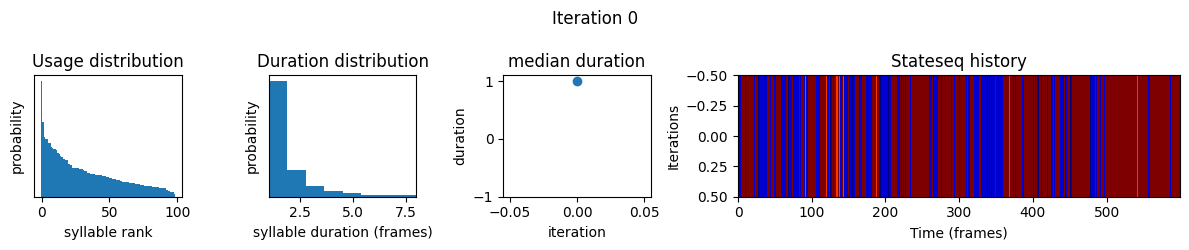

 20%|███████████████████████████████████████▏                                                                                                                                                                | 10/51 [02:07<08:32, 12.50s/it]

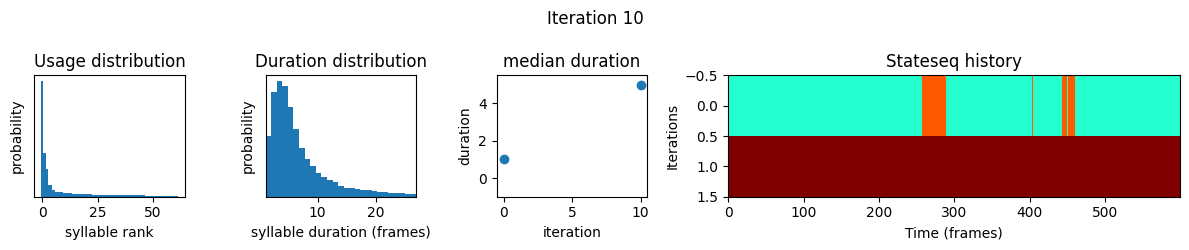

 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                     | 17/51 [03:36<07:07, 12.58s/it]

In [ ]:
model,history,name = kpm.fit_model(model, data, batch_info, ar_only=True, 
                                   num_iters=50, project_dir=project_dir)

### Step 3: Fitting keypoint-SLDS

The following code fits a keypoint-SLDS model, using the results of AR-HMM fitting for initialization
- If using your own data, you may need to try a few values of kappa at this step. 
- Use `kpm.revert` to resume from the same starting point each time you restart fitting

In [ ]:
# load model checkpoint generated during step 2 (AR-HMM fitting)
checkpoint = kpm.load_checkpoint(project_dir=project_dir, name=name)

# the following will cause fitting to resume from iteration 50, rather than the most recent iteration
# checkpoint = kpm.revert(checkpoint, 50)

# update kappa to maintain the desired syllable time-scale
checkpoint = kpm.update_hypparams(checkpoint, kappa=1e6)

model,history,name = kpm.resume_fitting(**checkpoint, project_dir=project_dir, 
                                        ar_only=False, num_iters=200, conf=None)


Outputs will be saved to demo_sleap_project\2023_01_06-05_20_44


  0%|                                                                                                                                                                                                                | 0/150 [00:00<?, ?it/s]

### Step 4: Apply the model

The code below infers a final syllable sequence for each experiment. The results are saved in `project_dir/name/results.h5`. 
- The default assumption is that `coordinates` and `confidences` are the same data that were used for model fitting.

To infer syllable sequences for new data:
- Run ``kpm.apply_model`` with `use_saved_states=False` and pass in a pca model
- Results for the new experiments will be added to the existing `results.h5` file.

In [ ]:
checkpoint = kpm.load_checkpoint(project_dir=project_dir, name=name)

confidences = None
results = kpm.apply_model(coordinates=coordinates, confidences=confidences, 
                          project_dir=project_dir, **checkpoint, **config())

# use this command if applying the model to new data
# results = kpm.apply_model(coordinates=coordinates, confidences=confidences, 
#                           use_saved_states=False, pca=kpm.load_pca(project_dir),
#                           project_dir=project_dir, **checkpoint, **config())

### Visualize results


In [ ]:
# generate plots showing the average keypoint trajectories for each syllable
kpm.generate_trajectory_plots(coordinates, name=name, project_dir=project_dir, **config())

In [ ]:
# generate video clips for each syllable
kpm.generate_crowd_movies(name=name, project_dir=project_dir, **config())